Project: Fake vs Real News

1) Imports


In [1]:
# text processing 
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# data handling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn .ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score,
                            confusion_matrix,
                            classification_report)

from gensim.models import Word2Vec
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


# saving and loading models
import joblib

# NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

2) Load Dataset & Basic Exploratory Data Analysis

In [2]:
# loading the dataset
df = pd.read_csv('dataset/data.csv')

val = pd.read_csv('dataset/validation_data.csv')

Shape: (39942, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39942 entries, 0 to 39941
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    39942 non-null  int64 
 1   title    39942 non-null  object
 2   text     39942 non-null  object
 3   subject  39942 non-null  object
 4   date     39942 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB
None


,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Missing values: label      0
title      0
text       0
subject    0
date       0
dtype: int64


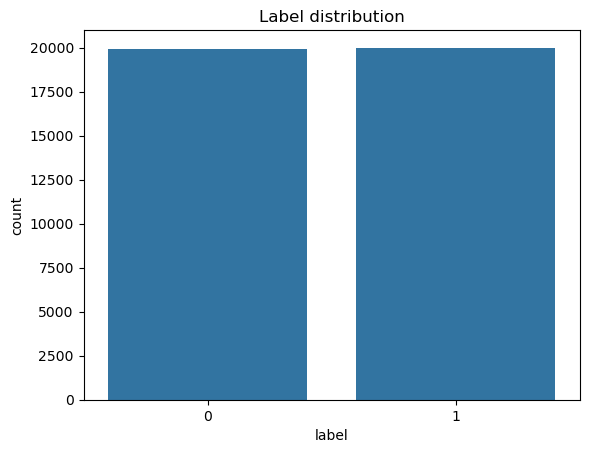

In [3]:
# displaying basic information about the dataset
print('Shape:', df.shape)
print(df.info())
display(df.head())

# checking for missing values 
print('Missing values:', df.isnull().sum())

# checking the distribution of labels
sns.countplot(x='label', data=df)
plt.title('Label distribution')
plt.show()

In [4]:
# deleting unnecessary columns
df = df.drop(columns = ['subject', 'date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39942 entries, 0 to 39941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   39942 non-null  int64 
 1   title   39942 non-null  object
 2   text    39942 non-null  object
dtypes: int64(1), object(2)
memory usage: 936.3+ KB


3) Text Cleaning Function

In [6]:
# text cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = str(text).lower() # convert to lowercase
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    words = text.split() # split into words

    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # lemmatization and stopword removal
    return ' '.join(words)

In [7]:
# concatenating and applying text cleaning to the dataset
df['all_text'] = (df['title'].fillna('') + ' ' + df['text'].fillna('')).apply(clean_text)


print(df['all_text'].head())

0    u budget fight loom republican flip fiscal scr...
1    u military accept transgender recruit monday p...
2    senior u republican senator let mr mueller job...
3    fbi russia probe helped australian diplomat ti...
4    trump want postal service charge much amazon s...
Name: all_text, dtype: object


4) Train/Test Split

In [10]:
# splitting the dataset into training and testing sets

X = df['all_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(df['all_text'], df['label'], test_size=0.2, random_state=42, stratify=y)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 31953
Testing set size: 7989


5) Evaluation Function

In [11]:

results = [] # variable to store results

# model evaluation function
def evaluate_model(name, model):
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', model)      
    ]) 
    # fitting on training split
    pipe.fit(X_train, y_train) 
    # predicting on test split
    y_pred = pipe.predict(X_test) 

    # calculating metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # displaying results
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # storing results
    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    }) 

    # plotting confusion matrix
    cm = confusion_matrix(y_test, y_pred) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

6) Comparing a Few Models

Model: Logistic Regression
Accuracy: 0.9845
Precision: 0.9814
Recall: 0.9878
F1 Score: 0.9846

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      3989
           1       0.98      0.99      0.98      4000

    accuracy                           0.98      7989
   macro avg       0.98      0.98      0.98      7989
weighted avg       0.98      0.98      0.98      7989



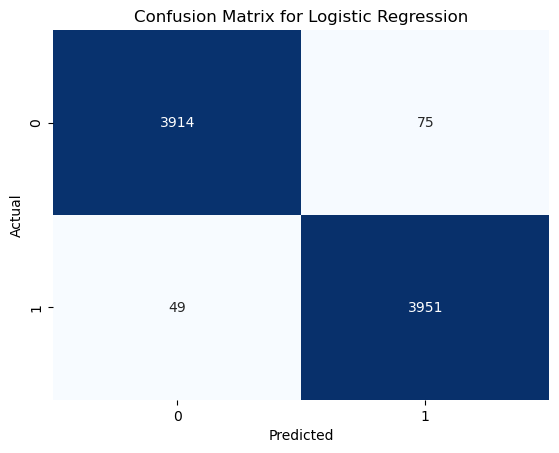

In [12]:
# evaluating Logistic Regression model
evaluate_model('Logistic Regression', LogisticRegression(max_iter=1000))

Model: Multinomial Naive Bayes
Accuracy: 0.9377
Precision: 0.9171
Recall: 0.9625
F1 Score: 0.9393

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      3989
           1       0.92      0.96      0.94      4000

    accuracy                           0.94      7989
   macro avg       0.94      0.94      0.94      7989
weighted avg       0.94      0.94      0.94      7989



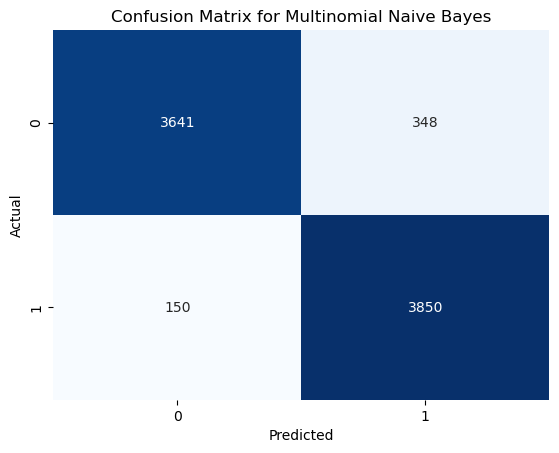

In [13]:
# evaluating Multinomial Naive Bayes model
evaluate_model('Multinomial Naive Bayes', MultinomialNB())

Model: Linear SVC
Accuracy: 0.9942
Precision: 0.9940
Recall: 0.9945
F1 Score: 0.9943

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3989
           1       0.99      0.99      0.99      4000

    accuracy                           0.99      7989
   macro avg       0.99      0.99      0.99      7989
weighted avg       0.99      0.99      0.99      7989



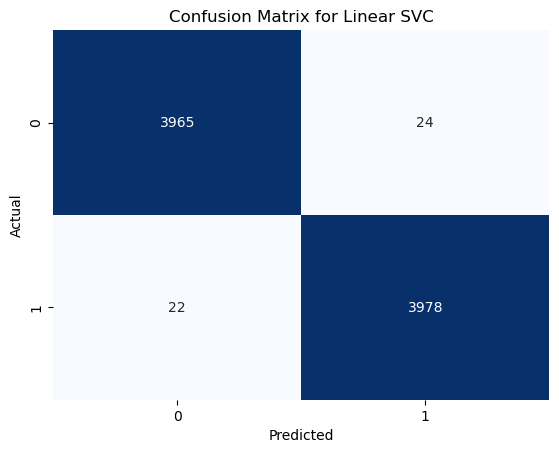

In [14]:
# evaluating Linear SVC model
evaluate_model('Linear SVC', LinearSVC())

Model: Random Forest
Accuracy: 0.9886
Precision: 0.9878
Recall: 0.9895
F1 Score: 0.9886

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3989
           1       0.99      0.99      0.99      4000

    accuracy                           0.99      7989
   macro avg       0.99      0.99      0.99      7989
weighted avg       0.99      0.99      0.99      7989



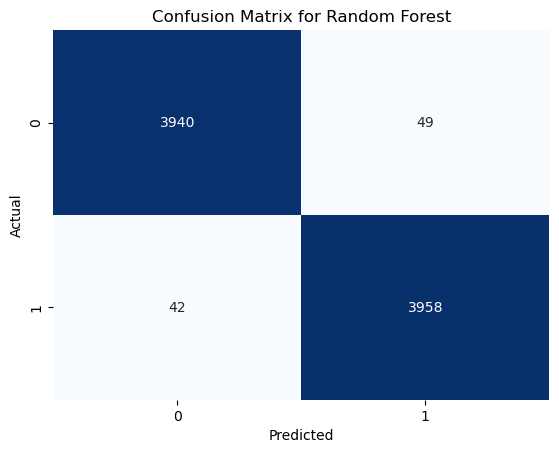

In [15]:
# evaluating Random Forest model
evaluate_model('Random Forest', RandomForestClassifier(n_estimators=300, random_state=42))

7. Word2Vec

In [16]:
# training W2V on training tokens
train_tok = [s.split() for s in X_train]
test_tok  = [s.split() for s in X_test]
w2v = Word2Vec(train_tok, vector_size=200, window=5, min_count=3, workers=4, sg=1, epochs=10)

# avg word vectors -> doc vector
import numpy as np
def _docvec(toks): 
    vs = [w2v.wv[w] for w in toks if w in w2v.wv]
    return np.mean(vs, axis=0) if vs else np.zeros(w2v.vector_size)
Xtr_w2v = np.vstack([_docvec(t) for t in train_tok])
Xte_w2v = np.vstack([_docvec(t) for t in test_tok])

# evaluating models with W2V features
def evaluate_w2v(name, clf):
    pipe = make_pipeline(StandardScaler(with_mean=True), clf)
    pipe.fit(Xtr_w2v, y_train)
    y_pred = pipe.predict(Xte_w2v)

    acc  = accuracy_score(y_test, y_pred); prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred);   f1   = f1_score(y_test, y_pred)
    print(f"\nModel: {name} (W2V)\nAccuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1 Score: {f1:.4f}\n")
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name} (W2V)'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

    results.append({'model': f'W2V - {name}', 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1})

8. Comparing a Few Models with Word2Vec


Model: Logistic Regression (W2V)
Accuracy: 0.9820
Precision: 0.9835
Recall: 0.9805
F1 Score: 0.9820

Classification Report:
               precision    recall  f1-score   support

           0     0.9805    0.9835    0.9820      3989
           1     0.9835    0.9805    0.9820      4000

    accuracy                         0.9820      7989
   macro avg     0.9820    0.9820    0.9820      7989
weighted avg     0.9820    0.9820    0.9820      7989



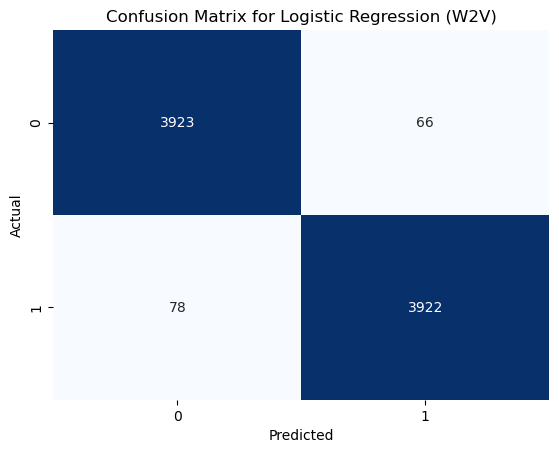

In [17]:
evaluate_w2v('Logistic Regression', LogisticRegression(max_iter=2000))


Model: Linear SVC (W2V)
Accuracy: 0.9824
Precision: 0.9825
Recall: 0.9822
F1 Score: 0.9824

Classification Report:
               precision    recall  f1-score   support

           0     0.9822    0.9825    0.9823      3989
           1     0.9825    0.9822    0.9824      4000

    accuracy                         0.9824      7989
   macro avg     0.9824    0.9824    0.9824      7989
weighted avg     0.9824    0.9824    0.9824      7989



/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


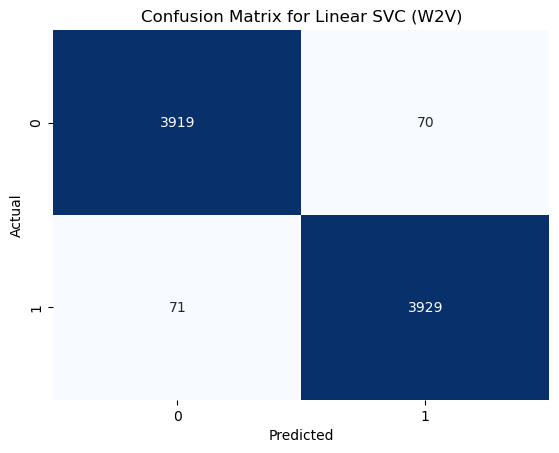

In [18]:
evaluate_w2v('Linear SVC', LinearSVC())


Model: Random Forest (W2V)
Accuracy: 0.9626
Precision: 0.9658
Recall: 0.9593
F1 Score: 0.9625

Classification Report:
               precision    recall  f1-score   support

           0     0.9594    0.9659    0.9626      3989
           1     0.9658    0.9593    0.9625      4000

    accuracy                         0.9626      7989
   macro avg     0.9626    0.9626    0.9626      7989
weighted avg     0.9626    0.9626    0.9626      7989



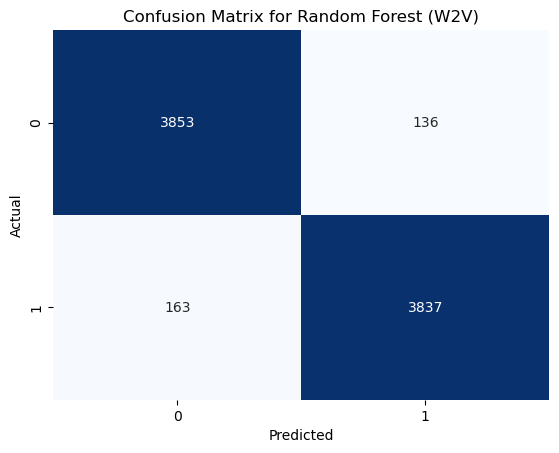

In [19]:
evaluate_w2v('Random Forest', RandomForestClassifier(n_estimators=300, random_state=42))

9. Model Performance Comparison 

Model Ranking


,model,accuracy,precision,recall,f1_score
0,Logistic Regression,0.984479,0.981371,0.98775,0.984550
1,Multinomial Naive Bayes,0.937664,0.917103,0.96250,0.939253
2,Linear SVC,0.994242,0.994003,0.99450,0.994251
3,Random Forest,0.988609,0.987771,0.98950,0.988635
4,W2V - Logistic Regression,0.981975,0.983450,0.98050,0.981973
5,W2V - Linear SVC,0.982351,0.982496,0.98225,0.982373
6,W2V - Random Forest,0.962574,0.965769,0.95925,0.962498


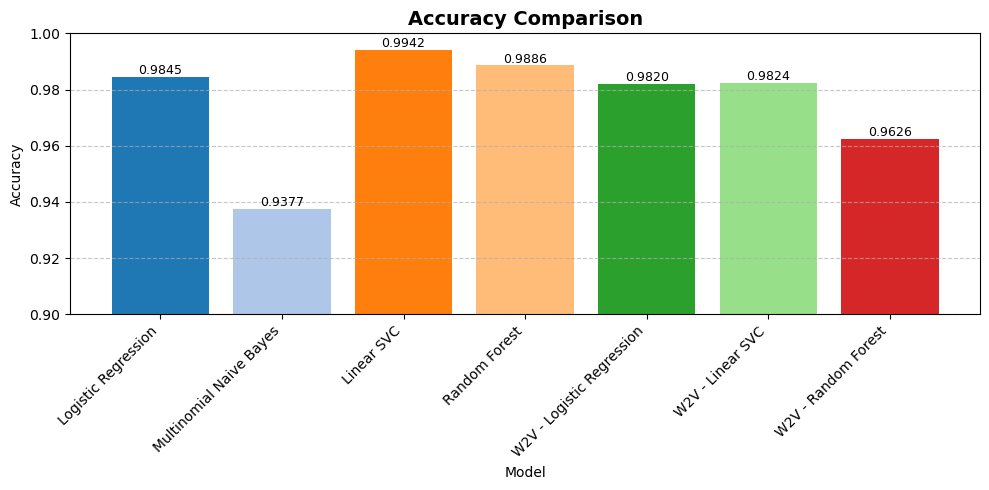

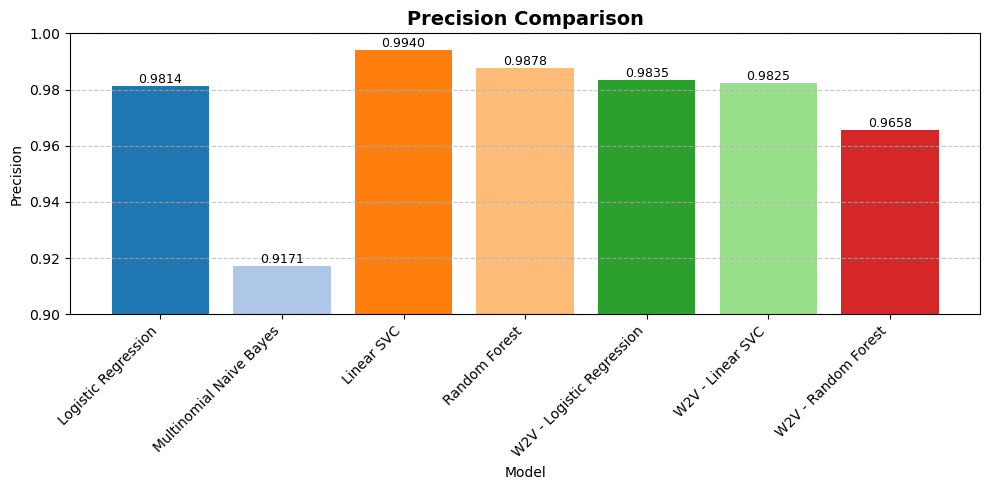

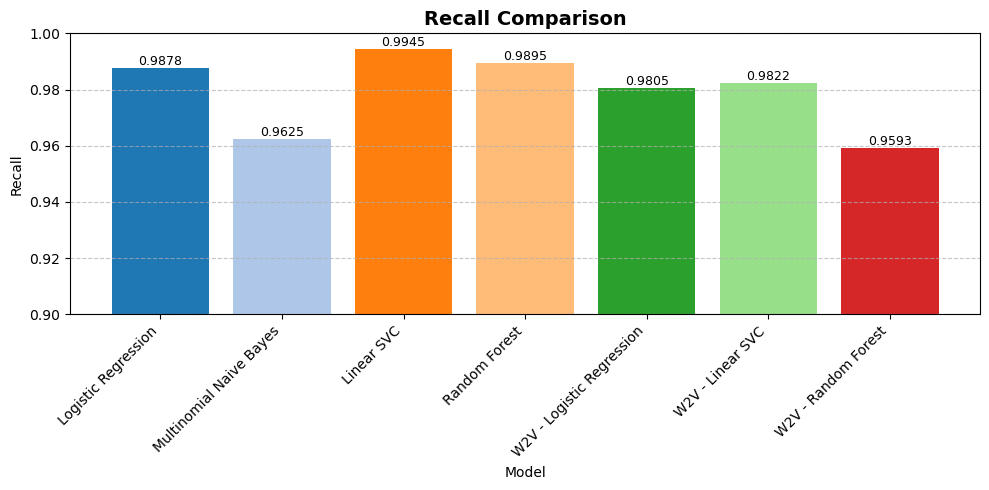

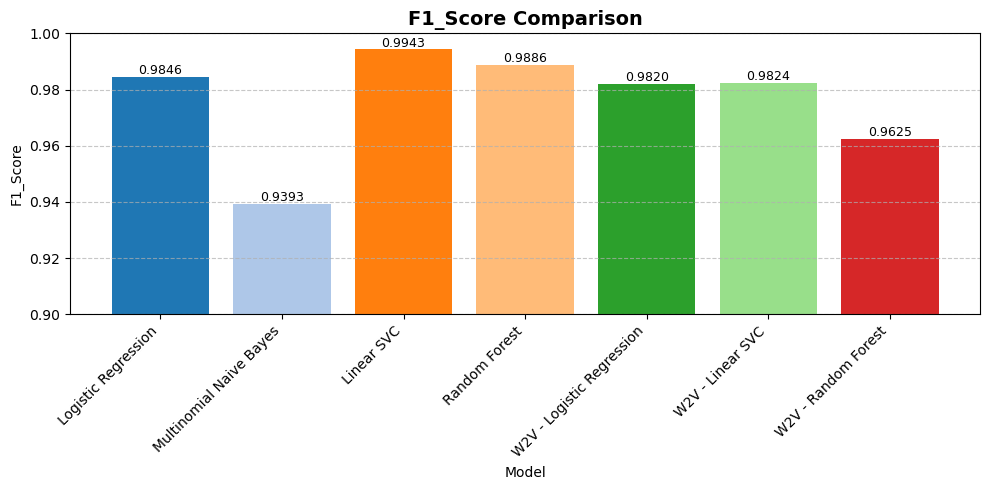

In [20]:
# compiling results into a DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True) # sorting by F1 score

# displaying the results
print("Model Ranking")
display(results_df)

metrics = ["accuracy", "precision", "recall", "f1_score"]

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot the metric for each model
    ax.bar(results_df['model'], results_df[metric], color=plt.cm.tab20.colors)
    
    # Add value labels on top of bars
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.001, f"{v:.4f}", ha='center', fontsize=9)
    
    # Formatting
    ax.set_ylim(0.9, 1.0)  # zoom in to see small differences
    ax.set_title(f"{metric.title()} Comparison", fontsize=14, fontweight='bold')
    ax.set_ylabel(metric.title())
    ax.set_xlabel("Model")
    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels(results_df['model'], rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

10. Train Linear SVC on 100% of the Data

In [21]:
# training Linear SVC on all data 
X_all = df['all_text']
y_all = df['label']

final_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LinearSVC())
])
final_pipe.fit(X_all, y_all)
print("✅ Linear SVC trained on full dataset.")


✅ Linear SVC trained on full dataset.


In [22]:
# saving the trained model
joblib.dump(final_pipe, 'linear_svc_model.pkl')
print("✅ Model saved as 'linear_svc_model.pkl'.")


✅ Model saved as 'linear_svc_model.pkl'.


11. Predict on validation_data.csv

Shape: (4956, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4956 entries, 0 to 4955
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    4956 non-null   int64 
 1   title    4956 non-null   object
 2   text     4956 non-null   object
 3   subject  4956 non-null   object
 4   date     4956 non-null   object
dtypes: int64(1), object(4)
memory usage: 193.7+ KB
None


,label,title,text,subject,date
0,2,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 15, 2017"
1,2,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,worldnews,"September 15, 2017"
2,2,Pacific nations crack down on North Korean shi...,WELLINGTON (Reuters) - South Pacific island na...,worldnews,"September 15, 2017"
3,2,Three suspected al Qaeda militants killed in Y...,"ADEN, Yemen (Reuters) - Three suspected al Qae...",worldnews,"September 15, 2017"
4,2,Chinese academics prod Beijing to consider Nor...,BEIJING (Reuters) - Chinese academics are publ...,worldnews,"September 15, 2017"


Missing values: label      0
title      0
text       0
subject    0
date       0
dtype: int64


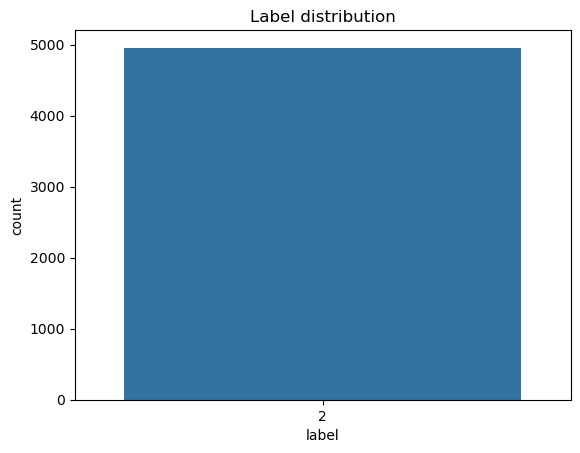

In [23]:
# displaying basic information about the dataset
print('Shape:', val.shape)
print(val.info())
display(val.head())

# checking for missing values and label distribution
print('Missing values:', val.isnull().sum())
sns.countplot(x='label', data=val)
plt.title('Label distribution')
plt.show()

In [24]:
# deleting unnecessary columns
val = val.drop(columns = ['subject', 'date'])

In [26]:
# checking
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4956 entries, 0 to 4955
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4956 non-null   int64 
 1   title   4956 non-null   object
 2   text    4956 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.3+ KB


In [27]:
# applying text cleaning to the dataset
val['all_text'] = (val['title'].fillna('') + ' ' + val['text'].fillna('')).apply(clean_text)


In [28]:
# predicting on validation data
val_preds = final_pipe.predict(val['all_text'])

# masking and updating labels
mask_two = val['label'] == 2
val.loc[mask_two, 'label'] = val_preds[mask_two]
val['label'] = val['label'].astype(int)

In [30]:
# checking if there are any labels equal to 2
(val['label'] == 2).any()

False

In [31]:
# displaying the first few rows of the validation data
val.head()

,label,title,text,all_text
0,1,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,uk may receiving regular update london tube st...
1,1,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,uk transport police leading investigation lond...
2,1,Pacific nations crack down on North Korean shi...,WELLINGTON (Reuters) - South Pacific island na...,pacific nation crack north korean ship fiji pr...
3,1,Three suspected al Qaeda militants killed in Y...,"ADEN, Yemen (Reuters) - Three suspected al Qae...",three suspected al qaeda militant killed yemen...
4,1,Chinese academics prod Beijing to consider Nor...,BEIJING (Reuters) - Chinese academics are publ...,chinese academic prod beijing consider north k...


In [32]:
# checking counts of each label
val['label'].value_counts()

label
0    3472
1    1484
Name: count, dtype: int64

In [33]:
# displaying a sample of predictions
sample = val.sample(5, random_state=42)
for _, row in sample.iterrows():
    print(f"Title: {row['title']}\nPredicted label: {row['label']}\n")

Title: PARENTS JAILED AND KIDS TAKEN AWAY FOR 90 MINUTE DELAY IN GETTING HOME TO 11-YEAR OLD
Predicted label: 0

Title: WHY TRUMP’S OWN CHILDREN WON’T Be Voting For Him In NY Primary
Predicted label: 0

Title: BREAKING #BALTIMORE RIOT VIDEOS: REPORT Black Guerrilla Family, Bloods And Crips Contracted To attack Baltimore Police
Predicted label: 0

Title: DONALD TRUMP STRIKES BACK: Reminds American Voters Bernie Sanders Is “A COMMUNIST”…And A COWARD [VIDEO]
Predicted label: 0

Title: Transylvanian dream: Juncker's antidote to 'Brexit nightmare'
Predicted label: 1



In [34]:
print(val['label'].unique())  # displaying unique labels in the original dataset

[1 0]


In [35]:
# saving the validation predictions to a CSV file
val.to_csv('dataset/validation_predictions.csv', index=False)
print("✅ Validation predictions saved to 'dataset/validation_predictions.csv'.")

✅ Validation predictions saved to 'dataset/validation_predictions.csv'.
